In [1]:
import os
import pandas as pd
import numpy as np
import ast
from collections import Counter
#visualisation
import seaborn as sn
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
# NLP
from nltk.corpus import stopwords
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer # bag of words
# Machine Learning
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Read Data

This data comes from https://www.kaggle.com/c/learn-ai-bbc/data

In [2]:
home_path = os.path.expanduser("~")
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text.csv'
df = pd.read_csv(fp)
df.head(2)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


### Exploratory Data Analysis

sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: category, dtype: float64

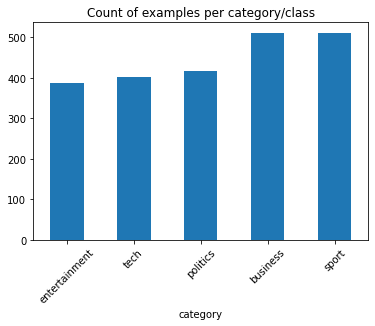

In [3]:
(f'Number of documents in dataset: {len(df)}')
display(df["category"].value_counts()/df.shape[0]) # Class distribution in the dataset
df.groupby('category').size().sort_values().plot.bar()
plt.title('Count of examples per category/class')
plt.xticks(rotation=45);

Business and Sport are best represented in the dataset.

Let's look at the count of character per category distributiom

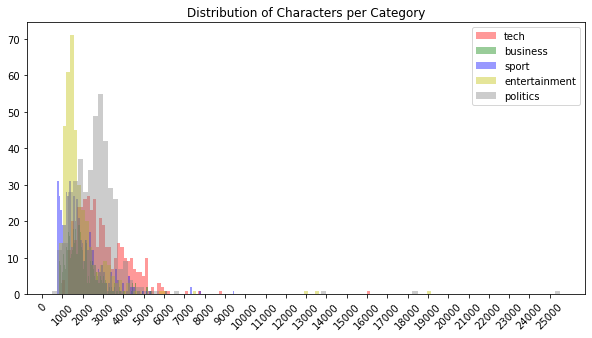

In [51]:
def plot_target_based_features(df, feature, title, interval_val):
    colors = ['r', 'g', 'b', 'y', 'grey']
    plt.figure(figsize=(10, 5))
    for category, color in zip(df['category'].unique(), colors):
        x = df[df['category'] == category][feature]
        ax = plt.hist(x, color=color, bins=100, label=category, alpha=0.4)
    plt.xticks(np.arange(0, max(x)+1, interval_val).astype(int), rotation=45)
    plt.title(title)
    plt.legend()
    plt.show()

df['text_len'] = df['text'].map(lambda x: len(x))
plot_target_based_features(df, 'text_len', 'Distribution of Characters per Category', 1000)

Looks like politics a higher frequency of more text (3000 words) and Entertainment has a high frequency of less text (1000). The other categories are a big more spread.

Number of unique words

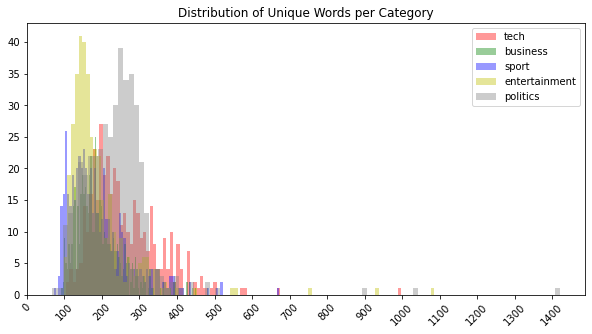

In [52]:
df['unique_word_count'] = df['text'].map(lambda x: len(set(str(x).split())))
plot_target_based_features(df, 'unique_word_count', 'Distribution of Unique Words per Category', 100)

Politics has more unique words. 

You can use this technique for all sorts of things e.g. count punctuation, numbers

Understanding distributions helps us understand more about the features going into our machine learning model.

### Preprocessing
lowercase strings, remove digits, punctuation, stopwords, and lemmatise.

When saving pandas dataframes as csv the list object is stored as a string, therefore the `ast.literal_eval` function converts it back to a list. Save as pickle to keep data types.

In [4]:
# Install the spaCy language model
# ! python -m spacy download en_core_web_sm

This script take ~30mins the first time.

In [56]:
%%time
mystopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')
def clean(doc):
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()]) # remove punctuation and numbers
    doc = [token.lower() for token in doc.split() if token not in mystopwords]
    doc = [w.lemma_ for word in doc for w in nlp(word)]
    return doc

df_preprop_fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text-preprocessed.csv'
if not os.path.exists(df_preprop_fp):
    df['prepro'] = df['text'].apply(clean)
    df.to_csv(df_preprop_fp, index=False)
    
else: # load preprocessed(lemmatisated) dataframe
    df = pd.read_csv(df_preprop_fp)
    df['prepro'] = df['prepro'].apply(ast.literal_eval) # convert str to list

CPU times: user 1.86 s, sys: 162 ms, total: 2.02 s
Wall time: 2.38 s


In [6]:
display(df.head(2))

,category,text,prepro
0,tech,tv future in the hands of viewers with home th...,"[tv, future, hand, viewer, home, theatre, syst..."
1,business,worldcom boss left books alone former worldc...,"[worldcom, boss, leave, book, alone, former, w..."


#### Investigate ngrams and bigrams
https://www.youtube.com/watch?v=MZIm_5NN3MY&list=PL7qHbYUK0G0oKwpedmafwocmnZmheyxgI&index=2

Top unigrams


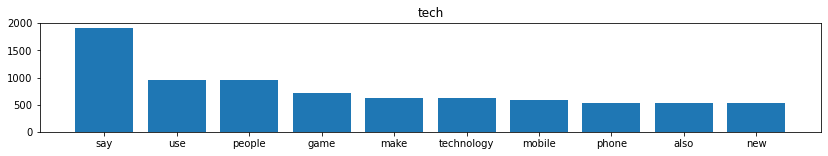

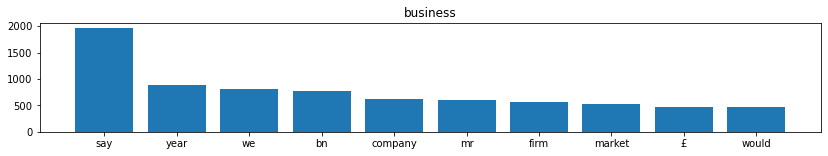

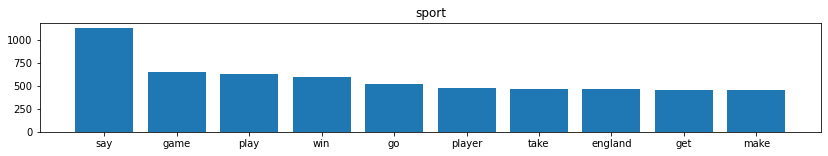

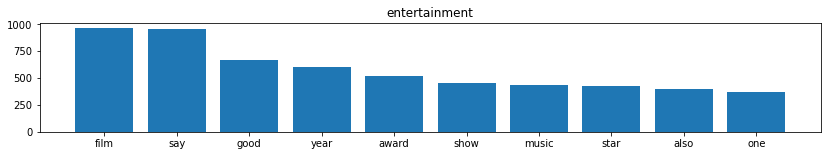

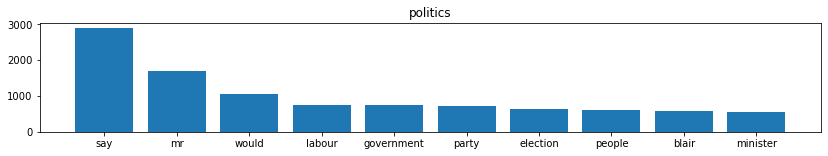

Top bigrams


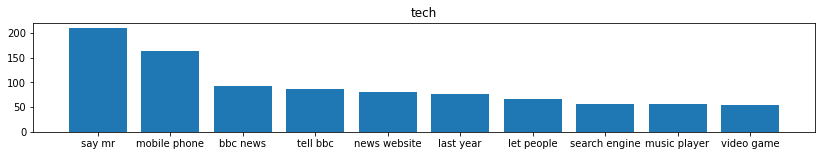

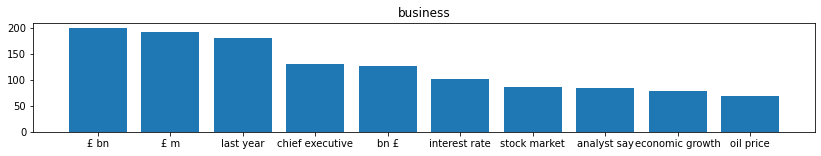

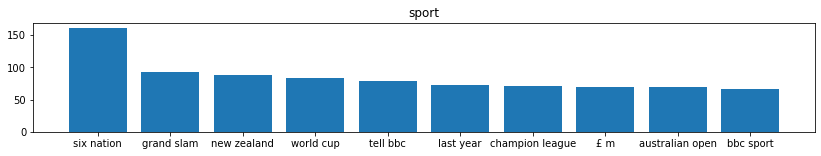

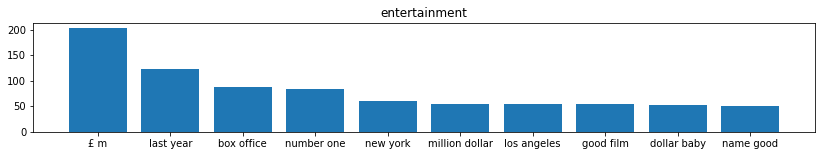

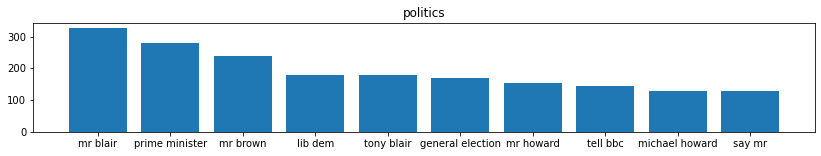

In [78]:
from collections import defaultdict

def create_ngrams_count_dict(df, category, n_gram=1):
    def generate_ngrams(text):
        z = zip(*[text[i:] for i in range(n_gram)])
        ngrams = [' '.join(ngram) for ngram in z]
        return ngrams
    
    ngrams_d = defaultdict(int)
    for text in df[df['category'] == category]['prepro']:
        for word in generate_ngrams(text):
            ngrams_d[word] += 1
    return ngrams_d

def plot_ngrams(df, title):
    d1 = df[0][:10]
    d2 = df[1][:10]
    plt.figure(figsize=(14, 2))
    plt.bar(d1, d2)
    plt.title(title)
    plt.show()


n_gram = 1
print(f'Top unigrams')
for category in df['category'].unique():
    ngram_d = create_ngrams_count_dict(df, category, n_gram)
    ngram_sorted_df = pd.DataFrame(sorted(ngram_d.items(), key=lambda x: x[1], reverse=True))
    plot_ngrams(ngram_sorted_df, category)


n_gram = 2
print(f'Top bigrams')
for category in df['category'].unique():
    ngram_d = create_ngrams_count_dict(df, category, n_gram)
    ngram_sorted_df = pd.DataFrame(sorted(ngram_d.items(), key=lambda x: x[1], reverse=True))
    plot_ngrams(ngram_sorted_df, category)

### Vectorisation of dataset
Bag of Words

In [88]:
ngram = (1,1)
count_vect = CountVectorizer(binary=True, ngram_range=ngram)
bow_rep = count_vect.fit_transform(df['prepro'].astype(str))
# create dataframe
df_bow = pd.DataFrame(bow_rep.toarray(), columns=count_vect.get_feature_names())
print(f'There are {len(df_bow.columns)} tokens in the bag of words')
df_bow.head(1)

There are 23431 tokens in the bag of words


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zuton,zvonareva,zvyagintsev
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each row in the bag of words refers to a document, so the length of bag of words and the labelled data should be the same. So the 0 index in df_bow is the 0 index in the df. 

In [89]:
len(df_bow), len(df)

(2225, 2225)

In [90]:
ngram = (2,2)
count_vect2 = CountVectorizer(binary=True, ngram_range=ngram)
bow_rep2 = count_vect2.fit_transform(df['prepro'].astype(str))
# create dataframe
df_bow2 = pd.DataFrame(bow_rep2.toarray(), columns=count_vect2.get_feature_names())
print(f'There are {len(df_bow2.columns)} tokens in the bag of words')
df_bow2.head(1)

There are 304301 tokens in the bag of words


,aa motor,aaa battery,aaa champion,aaa championship,aaa indoor,aaa sheffield,aaa title,aaas american,aaas champion,aaas championship,...,zurich londonbase,zurich opera,zurich premiership,zurich report,zuton estelle,zvonareva lose,zvonareva russia,zvonareva struggle,zvonareva wimbledon,zvyagintsev return
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
len(df_bow), len(df)

(2225, 2225)

### Modelling

We are going to use a logisitic regression model. 

Logistic regression is an example of a discriminative classifier and is commonly used in text classification, as a baseline in research, and as an MVP in real-world industry scenarios. Logistic regression “learns” the weights for individual features based on how important they are. The goal of logistic regression is to learn a linear separator between classes in the training data with the aim of maximizing the probability of the data. This “learning” of feature weights and probability distribution over all classes is done through a function called “logistic” function, and (hence the name) logistic regression. (Vajjala et al, Practical Natural Language Processing)

Split the data into training and testing with sklearn

`random_state` is for reproducibility

In [92]:
data, labels = df_bow, df['category']
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.25, random_state=42)
print(f'Training Data: {X_train.shape[0]}')
print(f'Testing Data: {X_test.shape[0]}')

Training Data: 1668
Testing Data: 557


Let's look at some of the data and labels. You will see that BoW is something like [0 0 0 ... 0 1 0].

In [93]:
idxs = [1, 10, -1]
for i in idxs:
    print(f'BoW: {X_train.iloc[i].values}\nCategory: {y_train.iloc[i]}')
    print((X_train.iloc[i][X_train.iloc[i] == 1]).index.tolist())

BoW: [0 0 0 ... 0 0 0]
Category: business
['account', 'also', 'average', 'bear', 'big', 'borrow', 'britannia', 'build', 'customer', 'december', 'depend', 'deposit', 'earn', 'either', 'eligibility', 'entitle', 'interest', 'introduce', 'invest', 'investment', 'large', 'last', 'least', 'less', 'make', 'member', 'mortgage', 'much', 'must', 'pay', 'payment', 'payout', 'permanent', 'pibs', 'point', 'profit', 'qualify', 'receive', 'result', 'reward', 'rule', 'scheme', 'second', 'share', 'society', 'stop', 'strict', 'two', 'uk', 'unveil', 'wednesday', 'windfall', 'worth', 'year']
BoW: [0 0 0 ... 0 0 0]
Category: politics
['across', 'add', 'affect', 'allpostal', 'along', 'area', 'assembly', 'ballot', 'bar', 'bbc', 'become', 'big', 'clear', 'closely', 'code', 'commission', 'complaint', 'council', 'count', 'county', 'couple', 'darlington', 'deliver', 'delivery', 'disappear', 'due', 'durham', 'east', 'elector', 'electoral', 'ensure', 'envelope', 'fail', 'far', 'find', 'go', 'hand', 'help', 'home',

We can see in the business example words such as pay, customer, share, profit. In the politics example words such as electoral, referendum, ballot. And in the tech example words such as text, service, phone, user, record (referring to a record number of text messages at new year!).

In [94]:
print('Model Training time:')
log_reg = LogisticRegression() # instantiate a logistic regression model
%time log_reg.fit(X_train, y_train) # train the model(timing it with an IPython "magic command")
y_pred_training_data = log_reg.predict(X_train) # make class predictions for X_train
print(accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

Model Training time:
CPU times: user 51.6 s, sys: 24.1 s, total: 1min 15s
Wall time: 10.7 s
1.0


100% accuracy on the training data set. The model has fit perfectly to the training data. 

Has it overfit to the data? To make sure we use the model to predict on the test dataset. 

### Accuracy Assessment

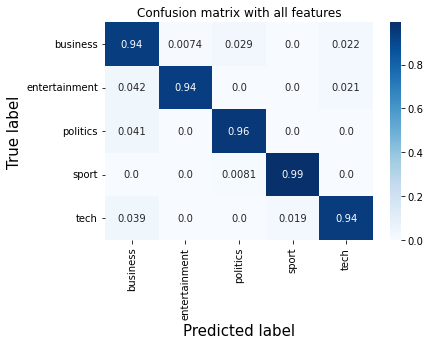

Accuracy:  0.9551166965888689


In [95]:
def plot_confusion_matrix(cm, classes, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalise
    sn.heatmap(cm, annot=True, fmt='.2', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.title(title)
    plt.show()

y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=y_pred))

The test data is unseen and therefore provides the final quality assurance for our model. 

That way we can run this model on future news data (that has no labels) and know that it will have an accuracy of around 95%. 

The model mostly was confused by business and entertainment and tech with entertainment. Tech and entertainment are the least represented classes in the dataset.

#### Which ones did it get wrong?

In [87]:
incorrect_predictions = np.where(y_test != y_pred)
idxs = y_test.index
for tuple_list in incorrect_predictions:
    for i in tuple_list:
        print(f'\nPredicted category: {y_pred[i]}')
        print(f'\nTrue category: {df.iloc[idxs]["category"].iloc[i]}')
        print(f'\nData: {df.iloc[idxs]["text"].iloc[i]}')
        print('###'*20)


Predicted category: business

True category: politics

Data: report attacks defence spending the ministry of defence has been criticised over the soaring spending costs and growing delays of its top equipment projects.  a national audit office report on the 20 biggest projects says costs have risen by £1.7bn in the past year. it says there is  little evidence  the mod s performance had improved  despite the introduction of a  smart acquisition  policy six years ago. a senior defence official told the bbc lessons were being learned. the nao s annual report showed the total cost of the 20 projects covered was expected to reach £50bn - 14% higher than originally planned. the total delays amounted to 62 months  with average individual delays rising by three months.  sir john bourn  head of the nao  said the problems showed the principles of the scheme known as smart acquisition had not been consistently applied.  many problems can be traced to the fact that the mod has not spent enough ti

The incorrect predictions are fair e.g. 
- predicted sport when the true category is tech because the news article is talking about a game called football manager.
- predicted politics when the true category is business because the new article discusses pensions, living standards and policy. 

It is worth noting that while the NLP model does perform well, the data that trained the model is time-specific e.g. technology words will change, politicians will come and go, new markets will emerge in business, news sporting heroes will win games and new actors/films/music will be popular. For a news NLP model to be successful it would most likely need continuous training. 

#### Bigram model

Training Data: 1668
Testing Data: 557
BoW: [0 0 0 ... 0 0 0]
Category: business
['account customer', 'account deposit', 'also qualify', 'also stop', 'average member', 'average payment', 'bear share', 'big last', 'borrow invest', 'britannia also', 'britannia build', 'britannia member', 'britannia unveil', 'build society', 'customer also', 'customer must', 'december britannia', 'depend much', 'deposit account', 'earn reward', 'either mortgage', 'eligibility rule', 'entitle share', 'interest bear', 'introduce pay', 'invest member', 'investment account', 'large build', 'last year', 'least two', 'less qualify', 'make payment', 'member earn', 'member least', 'member must', 'member receive', 'member share', 'member uk', 'member windfall', 'member worth', 'mortgage investment', 'much borrow', 'must either', 'must member', 'pay britannia', 'payment customer', 'payment member', 'payment qualify', 'payout big', 'permanent interest', 'pibs profit', 'point entitle', 'profit payout', 'profit share',

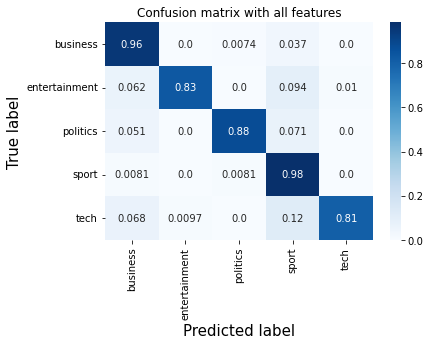

Accuracy:  0.8994614003590664


In [96]:
df_bow = df_bow2
data, labels = df_bow, df['category']
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.25, random_state=42)
print(f'Training Data: {X_train.shape[0]}')
print(f'Testing Data: {X_test.shape[0]}')
idxs = [1, 10, -1]
for i in idxs:
    print(f'BoW: {X_train.iloc[i].values}\nCategory: {y_train.iloc[i]}')
    print((X_train.iloc[i][X_train.iloc[i] == 1]).index.tolist())
    
print('Model Training time:')
log_reg = LogisticRegression() # instantiate a logistic regression model
%time log_reg.fit(X_train, y_train) # train the model(timing it with an IPython "magic command")
y_pred_training_data = log_reg.predict(X_train) # make class predictions for X_train
print(accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=y_pred))

Bigrams did not do as well with entertainment, politics and tech